# Video Face Recognition with YOLO Detection

This notebook combines YOLO for face detection with our trained face recognition model to identify people in videos with bounding boxes.

In [ ]:
import sys
sys.path.insert(0, '..')

import torch
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
import json
from tqdm import tqdm
from facenet_pytorch import MTCNN  # Proper face detector

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

## 1. Load MTCNN Face Detection Model

In [ ]:
# Load MTCNN for face detection
# MTCNN is specifically designed for face detection and works much better than general YOLO

face_detector = MTCNN(
    image_size=160,
    margin=20,
    min_face_size=20,
    thresholds=[0.6, 0.7, 0.7],  # Detection thresholds for 3 stages
    factor=0.709,
    post_process=False,
    keep_all=True,  # Return all detected faces
    device=device
)

print(f'MTCNN Face Detector loaded on {device}!')

MTCNN Face Detector loaded on cuda!


## 2. Load Face Recognition Model

In [ ]:
from src.models.classifier import FaceClassifier
from src.data.transforms import get_val_transforms

# Load the trained face recognition model
checkpoint_path = '../models/checkpoints/face_recognition.pt'

checkpoint = torch.load(checkpoint_path, map_location=device)

num_classes = checkpoint['num_classes']
class_names = checkpoint['class_names']
backbone = checkpoint.get('backbone', 'resnet50')

# Create model and load weights
face_recognizer = FaceClassifier(
    num_classes=num_classes,
    backbone=backbone,
    pretrained=False,
    dropout=0.3
).to(device)

face_recognizer.load_state_dict(checkpoint['model_state_dict'])
face_recognizer.eval()

print(f'Face recognition model loaded!')
print(f'Number of known people: {num_classes}')
print(f'Known people: {class_names[:10]}...')

Face recognition model loaded!
Number of known people: 50
Known people: ['Alejandro_Toledo', 'Alvaro_Uribe', 'Andre_Agassi', 'Ariel_Sharon', 'Arnold_Schwarzenegger', 'Atal_Bihari_Vajpayee', 'Bill_Clinton', 'Colin_Powell', 'David_Beckham', 'Donald_Rumsfeld']...


In [ ]:
# Setup image transforms for face recognition
IMAGE_SIZE = 224
transform = get_val_transforms(IMAGE_SIZE)

## 3. Video Face Recognition Pipeline

In [ ]:
class VideoFaceRecognizer:
    """Pipeline for detecting and recognizing faces in videos using MTCNN."""
    
    def __init__(self, face_detector, face_recognizer, class_names, transform, device='cuda', confidence_threshold=0.9):
        self.face_detector = face_detector
        self.face_recognizer = face_recognizer
        self.class_names = class_names
        self.transform = transform
        self.device = device
        self.confidence_threshold = confidence_threshold
        
    def detect_faces(self, frame):
        """Detect faces in a frame using MTCNN."""
        # Convert BGR (OpenCV) to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame_rgb)
        
        # Detect faces with MTCNN
        boxes, probs = self.face_detector.detect(frame_pil)
        
        detected_faces = []
        if boxes is not None:
            for box, prob in zip(boxes, probs):
                if prob >= self.confidence_threshold:
                    x1, y1, x2, y2 = [int(b) for b in box]
                    detected_faces.append((x1, y1, x2, y2, prob))
        
        return detected_faces
    
    def crop_face_region(self, frame, box, expand_ratio=0.1):
        """Crop face region from frame with slight expansion."""
        x1, y1, x2, y2, _ = box
        h, w = frame.shape[:2]
        
        # Expand box slightly for better face capture
        box_w = x2 - x1
        box_h = y2 - y1
        
        x1 = max(0, int(x1 - box_w * expand_ratio))
        y1 = max(0, int(y1 - box_h * expand_ratio))
        x2 = min(w, int(x2 + box_w * expand_ratio))
        y2 = min(h, int(y2 + box_h * expand_ratio))
        
        face_crop = frame[y1:y2, x1:x2]
        return face_crop, (x1, y1, x2, y2)
    
    def recognize_face(self, face_crop):
        """Recognize a face using the trained model."""
        if face_crop.size == 0 or face_crop.shape[0] < 10 or face_crop.shape[1] < 10:
            return None, 0.0
        
        # Convert BGR to RGB
        face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
        face_pil = Image.fromarray(face_rgb)
        
        # Apply transforms
        face_tensor = self.transform(face_pil).unsqueeze(0).to(self.device)
        
        # Get prediction
        with torch.no_grad():
            outputs = self.face_recognizer(face_tensor)
            probs = torch.softmax(outputs, dim=1)
            conf, pred = probs.max(dim=1)
            
        pred_idx = pred.item()
        confidence = conf.item()
        name = self.class_names[pred_idx]
        
        return name, confidence
    
    def process_frame(self, frame, recognition_threshold=0.3):
        """Process a single frame: detect faces and recognize them."""
        detections = self.detect_faces(frame)
        results = []
        
        for box in detections:
            face_crop, expanded_box = self.crop_face_region(frame, box)
            name, confidence = self.recognize_face(face_crop)
            
            if name and confidence >= recognition_threshold:
                results.append({
                    'box': expanded_box,
                    'name': name,
                    'confidence': confidence,
                    'detection_conf': box[4]
                })
            else:
                results.append({
                    'box': expanded_box,
                    'name': 'Unknown',
                    'confidence': confidence if confidence else 0.0,
                    'detection_conf': box[4]
                })
        
        return results
    
    def draw_results(self, frame, results):
        """Draw bounding boxes and labels on frame."""
        frame_draw = frame.copy()
        
        for result in results:
            x1, y1, x2, y2 = result['box']
            name = result['name'].replace('_', ' ')
            conf = result['confidence']
            
            # Color based on recognition confidence
            if result['name'] == 'Unknown':
                color = (0, 0, 255)  # Red for unknown
            else:
                color = (0, 255, 0)  # Green for recognized
            
            # Draw bounding box
            cv2.rectangle(frame_draw, (x1, y1), (x2, y2), color, 2)
            
            # Draw label background
            label = f'{name} ({conf:.2f})'
            (label_w, label_h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(frame_draw, (x1, y1 - label_h - 10), (x1 + label_w, y1), color, -1)
            
            # Draw label text
            cv2.putText(frame_draw, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        return frame_draw
    
    def process_video(self, input_path, output_path, recognition_threshold=0.3, show_progress=True):
        """Process entire video and save with face recognition annotations."""
        cap = cv2.VideoCapture(input_path)
        
        if not cap.isOpened():
            raise ValueError(f'Cannot open video: {input_path}')
        
        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        print(f'Video: {width}x{height} @ {fps}fps, {total_frames} frames')
        print(f'Using device: {self.device}')
        
        # Create video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        # Process frames
        pbar = tqdm(total=total_frames, desc='Processing video') if show_progress else None
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Process frame
            results = self.process_frame(frame, recognition_threshold)
            annotated_frame = self.draw_results(frame, results)
            
            # Write frame
            out.write(annotated_frame)
            
            if pbar:
                pbar.update(1)
        
        if pbar:
            pbar.close()
        
        cap.release()
        out.release()
        
        print(f'Output saved to: {output_path}')
        return output_path

In [ ]:
# Initialize the video face recognizer
video_recognizer = VideoFaceRecognizer(
    face_detector=face_detector,
    face_recognizer=face_recognizer,
    class_names=class_names,
    transform=transform,
    device=device,
    confidence_threshold=0.5  # YOLO detection threshold
)

print('Video Face Recognizer initialized!')

Video Face Recognizer initialized!


## 4. Test on Sample Image

Testing on: ..\data\lfw-deepfunneled\lfw-deepfunneled\Aaron_Eckhart\Aaron_Eckhart_0001.jpg


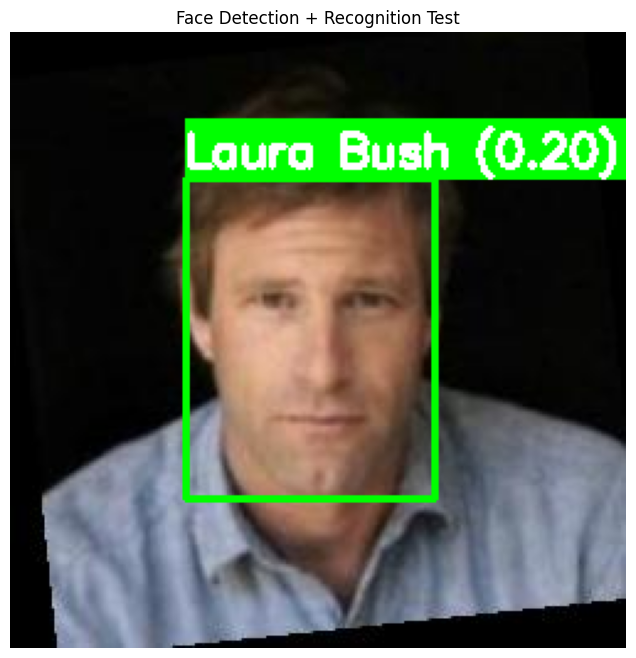

Detected 1 face(s)
  - Laura_Bush: 20.05%


In [ ]:
import matplotlib.pyplot as plt

# Test on a sample image from the dataset
sample_dir = Path('../data/lfw-deepfunneled/lfw-deepfunneled')
sample_person = list(sample_dir.iterdir())[0]  # Get first person
sample_image = list(sample_person.iterdir())[0]  # Get first image

print(f'Testing on: {sample_image}')

# Load and process image
frame = cv2.imread(str(sample_image))
results = video_recognizer.process_frame(frame, recognition_threshold=0.1)
annotated = video_recognizer.draw_results(frame, results)

# Display
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Face Detection + Recognition Test')
plt.show()

print(f'Detected {len(results)} face(s)')
for r in results:
    print(f"  - {r['name']}: {r['confidence']:.2%}")

Testing on known person: ..\data\lfw-deepfunneled\lfw-deepfunneled\George_W_Bush\George_W_Bush_0001.jpg


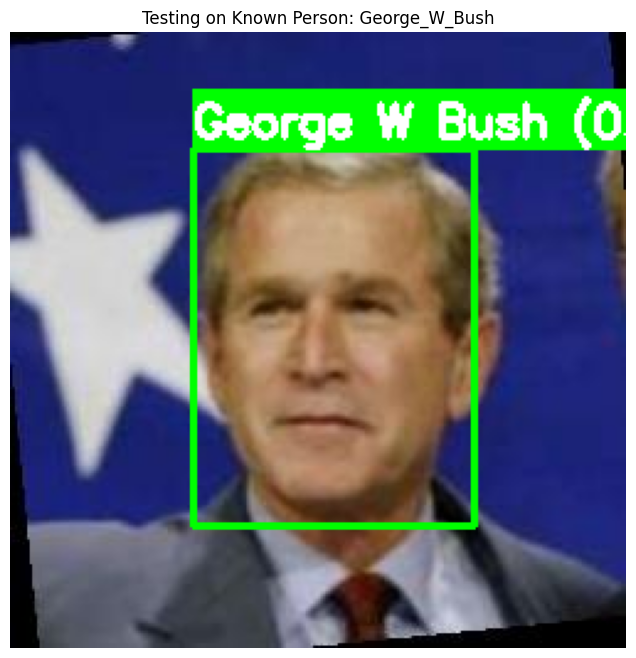

Detected 1 face(s)
  - George_W_Bush: 96.88%


In [ ]:
# Test on a known person from our training set
known_person = 'George_W_Bush'  # One of the 50 people in training set
known_dir = Path(f'../data/lfw-deepfunneled/lfw-deepfunneled/{known_person}')

if known_dir.exists():
    sample_image = list(known_dir.iterdir())[0]
    print(f'Testing on known person: {sample_image}')
    
    frame = cv2.imread(str(sample_image))
    results = video_recognizer.process_frame(frame, recognition_threshold=0.1)
    annotated = video_recognizer.draw_results(frame, results)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Testing on Known Person: {known_person}')
    plt.show()
    
    print(f'Detected {len(results)} face(s)')
    for r in results:
        print(f"  - {r['name']}: {r['confidence']:.2%}")
else:
    print(f'Directory not found: {known_dir}')

## 5. Process Video

In [ ]:
# Define input and output paths
# Replace with your video path
INPUT_VIDEO = '../assets/test4.mp4'  # Path to your input video
OUTPUT_VIDEO = '../outputs/face_recognition_output.mp4'

# Create output directory
Path('../outputs').mkdir(exist_ok=True)

# Check if input video exists
if Path(INPUT_VIDEO).exists():
    # Process video
    video_recognizer.process_video(
        input_path=INPUT_VIDEO,
        output_path=OUTPUT_VIDEO,
        recognition_threshold=0.3  # Minimum confidence to show name
    )
else:
    print(f'Input video not found: {INPUT_VIDEO}')
    print('Please update INPUT_VIDEO path to your video file.')

NameError: name 'Path' is not defined

## 6. Real-time Webcam Face Recognition

In [ ]:
def run_webcam_recognition(recognizer, recognition_threshold=0.3):
    """Run real-time face recognition on webcam feed."""
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print('Cannot open webcam')
        return
    
    print('Press Q to quit')
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Process frame
        results = recognizer.process_frame(frame, recognition_threshold)
        annotated = recognizer.draw_results(frame, results)
        
        # Display
        cv2.imshow('Face Recognition', annotated)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

# Uncomment to run webcam recognition
# run_webcam_recognition(video_recognizer)

## 7. Alternative: Use YOLO Face-Specific Model

For better face detection, you can use a YOLO model specifically trained for faces.

In [ ]:
# Download and use YOLOv8 face model for better face detection
# This requires downloading yolov8n-face.pt from: https://github.com/akanametov/yolov8-face

def load_yolo_face_model():
    """Load YOLO face-specific model."""
    face_model_path = '../models/checkpoints/yolov8n-face.pt'
    
    if Path(face_model_path).exists():
        return YOLO(face_model_path)
    else:
        print(f'Face model not found at {face_model_path}')
        print('Using standard YOLO model instead.')
        print('For better results, download yolov8n-face.pt from:')
        print('https://github.com/akanametov/yolov8-face')
        return YOLO('yolov8n.pt')

# Uncomment to use face-specific YOLO model
# face_detector = load_yolo_face_model()

## 8. Save Complete Pipeline as Module

In [ ]:
# Save the VideoFaceRecognizer class to a Python file for reuse
pipeline_code = '''
"""Video Face Recognition Pipeline using YOLO + Trained Classifier."""

import torch
import cv2
import numpy as np
from pathlib import Path
from ultralytics import YOLO
from PIL import Image
from tqdm import tqdm

from src.models.classifier import FaceClassifier
from src.data.transforms import get_val_transforms


class VideoFaceRecognizer:
    """Pipeline for detecting and recognizing faces in videos."""
    
    def __init__(self, face_detector, face_recognizer, class_names, transform, 
                 device='cuda', confidence_threshold=0.5):
        self.face_detector = face_detector
        self.face_recognizer = face_recognizer
        self.class_names = class_names
        self.transform = transform
        self.device = device
        self.confidence_threshold = confidence_threshold
        
    @classmethod
    def from_checkpoint(cls, checkpoint_path, yolo_model='yolov8n.pt', device=None):
        """Create VideoFaceRecognizer from saved checkpoint."""
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Load face detector
        face_detector = YOLO(yolo_model)
        
        # Load face recognizer
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        num_classes = checkpoint['num_classes']
        class_names = checkpoint['class_names']
        backbone = checkpoint.get('backbone', 'resnet50')
        
        face_recognizer = FaceClassifier(
            num_classes=num_classes,
            backbone=backbone,
            pretrained=False,
            dropout=0.3
        ).to(device)
        
        face_recognizer.load_state_dict(checkpoint['model_state_dict'])
        face_recognizer.eval()
        
        # Transform
        transform = get_val_transforms(224)
        
        return cls(face_detector, face_recognizer, class_names, transform, device)
    
    def detect_faces(self, frame):
        """Detect faces in a frame using YOLO."""
        results = self.face_detector(frame, verbose=False)
        boxes = []
        
        for result in results:
            for box in result.boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                
                if conf >= self.confidence_threshold:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                    boxes.append((x1, y1, x2, y2, conf))
        
        return boxes
    
    def crop_face_region(self, frame, box, expand_ratio=0.2):
        """Crop and preprocess face region from frame."""
        x1, y1, x2, y2, _ = box
        h, w = frame.shape[:2]
        
        box_w = x2 - x1
        box_h = y2 - y1
        
        x1 = max(0, int(x1 - box_w * expand_ratio))
        y1 = max(0, int(y1 - box_h * expand_ratio))
        x2 = min(w, int(x2 + box_w * expand_ratio))
        y2 = min(h, int(y2 + box_h * expand_ratio))
        
        face_crop = frame[y1:y2, x1:x2]
        return face_crop, (x1, y1, x2, y2)
    
    def recognize_face(self, face_crop):
        """Recognize a face using the trained model."""
        if face_crop.size == 0:
            return None, 0.0
        
        face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
        face_pil = Image.fromarray(face_rgb)
        
        face_tensor = self.transform(face_pil).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.face_recognizer(face_tensor)
            probs = torch.softmax(outputs, dim=1)
            conf, pred = probs.max(dim=1)
            
        pred_idx = pred.item()
        confidence = conf.item()
        name = self.class_names[pred_idx]
        
        return name, confidence
    
    def process_frame(self, frame, recognition_threshold=0.3):
        """Process a single frame: detect faces and recognize them."""
        detections = self.detect_faces(frame)
        results = []
        
        for box in detections:
            face_crop, expanded_box = self.crop_face_region(frame, box)
            name, confidence = self.recognize_face(face_crop)
            
            if name and confidence >= recognition_threshold:
                results.append({\'box\': expanded_box, \'name\': name, \'confidence\': confidence})
            else:
                results.append({\'box\': expanded_box, \'name\': \'Unknown\', \'confidence\': confidence or 0.0})
        
        return results
    
    def draw_results(self, frame, results):
        """Draw bounding boxes and labels on frame."""
        frame_draw = frame.copy()
        
        for result in results:
            x1, y1, x2, y2 = result[\'box\']
            name = result[\'name\'].replace(\'_\', \' \')
            conf = result[\'confidence\']
            
            color = (0, 0, 255) if result[\'name\'] == \'Unknown\' else (0, 255, 0)
            
            cv2.rectangle(frame_draw, (x1, y1), (x2, y2), color, 2)
            
            label = f\'{name} ({conf:.2f})\'
            (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(frame_draw, (x1, y1 - label_h - 10), (x1 + label_w, y1), color, -1)
            cv2.putText(frame_draw, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        return frame_draw
    
    def process_video(self, input_path, output_path, recognition_threshold=0.3, show_progress=True):
        """Process entire video and save with face recognition annotations."""
        cap = cv2.VideoCapture(input_path)
        
        if not cap.isOpened():
            raise ValueError(f\'Cannot open video: {input_path}\')
        
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        fourcc = cv2.VideoWriter_fourcc(*\'mp4v\')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        pbar = tqdm(total=total_frames, desc=\'Processing video\') if show_progress else None
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            results = self.process_frame(frame, recognition_threshold)
            annotated_frame = self.draw_results(frame, results)
            out.write(annotated_frame)
            
            if pbar:
                pbar.update(1)
        
        if pbar:
            pbar.close()
        
        cap.release()
        out.release()
        
        return output_path
'''

# Save to file
with open('../app/video_recognizer.py', 'w') as f:
    f.write(pipeline_code)

print('Pipeline saved to ../app/video_recognizer.py')

Pipeline saved to ../app/video_recognizer.py


## Usage Example

```python
from app.video_recognizer import VideoFaceRecognizer

# Load from checkpoint
recognizer = VideoFaceRecognizer.from_checkpoint(
    checkpoint_path='models/checkpoints/face_recognition.pt',
    yolo_model='yolov8n.pt'
)

# Process video
recognizer.process_video(
    input_path='data/my_video.mp4',
    output_path='outputs/annotated_video.mp4',
    recognition_threshold=0.3
)
```